# Extended Beam Modeling with `xbmodeling` 
## A tutorial notebook
### Tyler St Germaine, James Cornelison, Gabriel Rabanal
### Phys 201 Spring 2020 Final Project
___

### Section 0: Setting up the code locally

Before we talk about the model and what we're trying to solve, let's get everything installed and able to run on your computer.  After cloning the [repository](https://github.com/phys201/extended-beam-modeling), you'll want to go to the root directory and run the following:

`pip install .`

`python setup.py test`

Obviously the first line will get everything installed -- we specifically rely on a package called [healpy](https://healpy.readthedocs.io/en/latest/) which is not installed by default in anaconda.  The second line will also run some basic tests we've written to make sure everything will run smoothly when you try using the model.

Once everything is installed, you should be able to run these imports in this notebook (you may have to restart the kernel):

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import healpy as hp
import emcee
import multiprocessing
import pandas as pd
import seaborn as sns
import sys
import xbmodeling as xb
import xbmodeling.gen_model as gm
import xbmodeling.pointing_model as pnt
from xbmodeling.config import modelconf
from xbmodeling.config import mountconf

___


### Section 1: The Problem

[BICEP/Keck](bicepkeck.org) is a series of polarimeters at the South Pole observing the Cosmic Microwave Background (CMB), looking for the signal of primordial inflation.  Each pixel in our telescope comprises two co-located, orthogonally polarized detectors.  We call one detector the "A" detector and the other the "B" detector.  Each detector has its own spatial response pattern, or *beam*, which we'll call $B_A$ and $B_B$ -- you can think of this as an equivalent to a point spread function.

We can measure intensity (often called temperature in this field) by summing together the signals from these two detectors in each pixel, and we can measure polarization by taking the difference.   For a full discussion on all the various components of a polarization timestream for a given pixel, see the section **Detector timestreams** in our jupyter notebook describing the model, `model_test.ipynb`.  The final equation for the polarization timestream looks like this:

$$d_A-d_B = \left[B_A-B_B\right]\ast T + \left[B_A+B_B\right]\ast Q\cos(2\psi_A)+\left[B_A+B_B\right]\ast U\sin(2\psi_A)$$

where $d_A$ ($d_B$) is the signal from the A (B) detector, $T$ is the temperature of whatever is being observed, and $Q$/$U$ are Stokes parameters describing the polarization of whatever is being observed ($\psi_A$ describes the polarization angles of the detectors -- we won't worry about that for now).  Also note that $\ast$ denotes a convolution.

Notice the first term in that equation: $\left[B_A-B_B\right]\ast T$.  This tells us that if the two detectors in a pixel have a different beam, our _polarization_ timestream will have a component that is sensitive to *temperature*, which is a major problem because the temperature (remember, this is intensity) is orders of magnitude brighter than polarization!

One possible way that two detectors in a pixel can have different beams is in their *extended response*.  Normally, each detector's beam is simply a 2D Gaussian centered right where the detector is looking (again, think of the analogy to PSFs).  But due to imperfections in the telescope optics, it's possible for there to be extended response -- sensitivity to something very far away from where the detector is actually pointing!  Through this model and comparisons to real BICEP/Keck data, we hope to understand the shape and relative amplitude of this extended response. 

___


### Section 2: Handling BICEP/Keck Data

Before we get into the model, let's load some real data timestreams and see what it looks like.  The data handling is done in the script `io.py`.  We have some sample data included in `input_data/bicepkeck_tods` -- let's load it up!

In [2]:
datafile = "xbmodeling/input_data/bicepkeck_tods/20150531C01_dk068_tod_singlepair.mat"
tod_full, scans, det_info = xb.io.load_tod_file(datafile)

`tod_full` is a `pandas` DataFrame which has raw detector timestreams for each detector (A and B), as well as timestreams of the telescope pointing, including horizon coordinates (azimuth, elevation, dk angle) and celestial coordinates (right ascension, declination, dk angle).  Note that the BICEP/Keck telescope are able to rotate about the boresight axis.  We call the angle of this rotation at any time the dk ("deck") angle.

The plot below shows the telescope azimuth timestream for this chunk of data (we call each chunk of data like this a "tag").  Our scan strategy in each tag is to scan back and forth in azimuth at the same elevation.  We see that in the plot, but we also see some non-useful data before and after it.

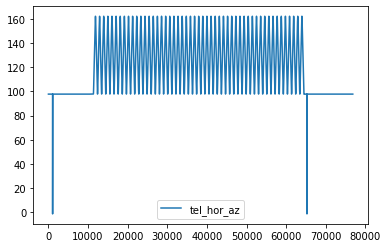

In [3]:
tod_full.plot(y="tel_hor_az");

The function `keep_scans` will use the `scans` DataFrame to trim down the data to a certain number of azimuth scans.  This is useful for trimming the data to only what we need.  The example below keeps only the first four "half-scans".  First, a time vector is hardcoded into our dataframe -- this feature is being added to `load_tod_file` but for now we stick it in manually.

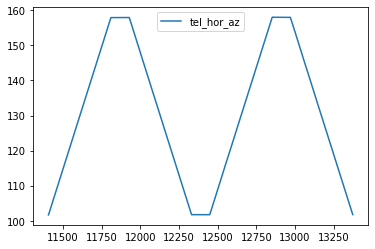

In [4]:
tod_full["time_utc"] = np.arange(np.size(tod_full["A_sig"]))/20. / 3600 / 24 

tod = xb.io.keep_scans(tod_full,scans,[0,1,2,3])
tod.plot(y='tel_hor_az');

The detector timestreams for the same time frame look like this:

Text(0.5, 1.0, 'Polarizaton Data Timestream')

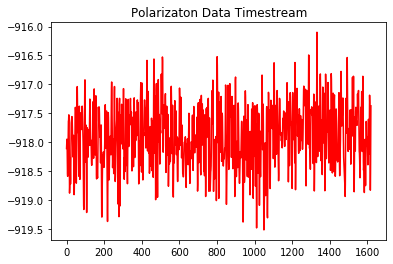

In [5]:
A_data = tod['A_sig'].values.ravel()
B_data = tod['B_sig'].values.ravel()
plt.plot(A_data-B_data,'r');
plt.title('Polarizaton Data Timestream')

The last bit of useful data output from `load_tod_file` is `det_info`, another DataFrame which contains auxillary info for that detector pair.  Specifically, it contains the pointing for that pixel -- the telescope may be pointing at some spot on the sky (what's plotted two plots above), but a given pixel will be offset from the telescope center by some amount.  That is the info contained in `r` and `theta` below, which we'll need later when we are simulating timestreams.

In [6]:
det_info

,r,theta,ukpervolt,drumangle
0,6.563852,-140.197999,1921.0,211.0
1,6.563852,-140.197999,1921.0,211.0


___


### Section 3: The Model

A complete description of the model is in our other notebook `model_test.ipynb`.  Here we give a brief description and play with some of its tools.  

We've described the problem so far and what some real data looks like, but what are we modeling?  The model is the spatial response of the detectors, i.e. the beams.  For each detector (A and B) we model a "main" beam -- a 2D Gaussian centered exactly where the pixel is pointing on the sky, and an "extended" beam -- a broader, diffuse 2D Gaussian centered far from the main beam.

We simulate a tag (the amount of data shown in the previous section) by using the real telescope pointing timestreams, simulated beams for the A and B detectors made by the model, and a model for the full CMB sky and ground.  (Note that we are modeling the sky and ground, but these are not parameters we are conditioning on or marginalizing over -- we take these to be true and fixed for now.)  At each timestep in an observation, the simulation follows exactly the equation given at the top of this notebook.  We convolve the difference beam $B_A - B_B$ with the temperature sky + ground $T$ and the sum beam $B_A + B_B$ with the polarized sky + ground $Q$ and $U$.  The module `gen_model` does all of this work.

At the end we have a full simulated timestream which is the exact same size as the real timestream, like the one plotted above.  We can then run an MCMC, iterating over the parameters describing the main and extended beams, and use our familiar tools for estimating the posterior (this will be covered later in the notebook).

One part of `gen_model` is creating the template for the sky and ground.  Let's load and plot a real map of the CMB.  

/n/home05/grabanal/.conda/envs/phys201/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Current map NSIDE=512. Converting to NSIDE=64


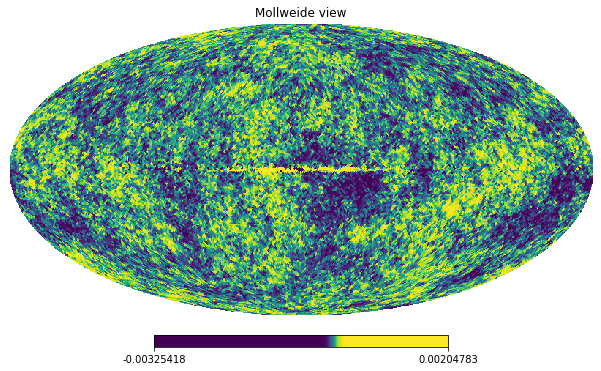

In [7]:
nside = 64
cmbmap = gm.make_cmb_map(modelconf["cmbFile"], nside_out=nside)
hp.mollview(cmbmap[0,:],norm="hist")

`nside` is a parameter related to the resolution of the map (see details [here](https://lambda.gsfc.nasa.gov/toolbox/tb_pixelcoords.cfm)).  A higher number means a better resolution but a slower run time for our model.  It must be a factor of two.  

The output `cmbmap` will have three maps -- temperature, Q, and U in that order.  We plotted temperature above.

But the sky is not the only thing the detectors might see -- they could overlap with the ground, especially if there is extended response.  At the South Pole, the ground is nicely very flat in all directions, so we can simply model it as a single temperature for all points on the sky below elevation of zero (or above declination of zero).  The function `make_ground_template` creates a map of the ground in the same format as `cmbmap`, with the temperature of the ground in K as input.

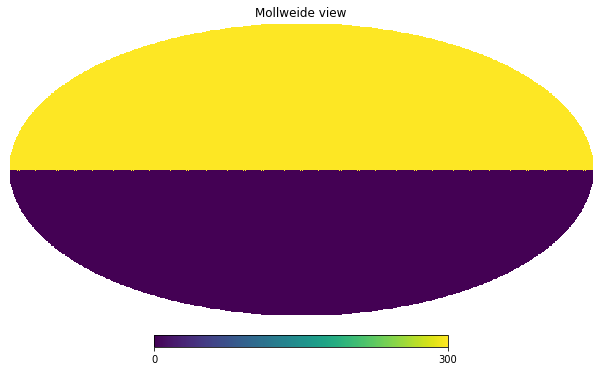

In [8]:
groundmap = gm.make_ground_template(300,nside)
hp.mollview(groundmap)

The most important element of the model is the model for the beams.  For now, we've modeled it as two independent main beams and extended beams (one each for A and one for B).  The function `make_composite_map` will make a main beam and an extended beam and add them together for one detector.  Below I make an example beam.  In this example I make the beams unrealistically large just so we can visualize them nicely.

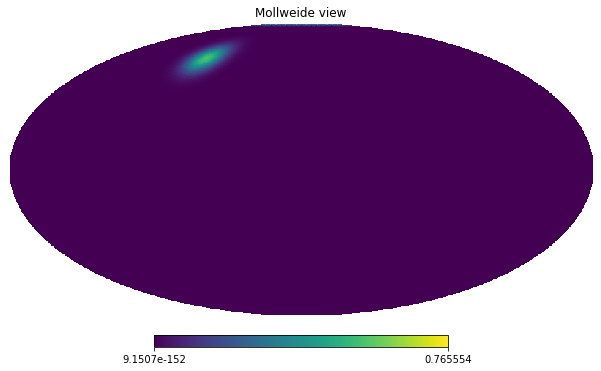

In [9]:
A_main_param = [1, 0, 0, 3, 3, 1]
A_extended_param = [0.5, 0, 30, 30, 30, 0]
A_beam = gm.make_composite_map(A_main_param, A_extended_param, nside=nside)
hp.mollview(A_beam)

The class **GenModelMap** handles all the information we've played with so far, and does the actual simulations given some telescope and detector info that we looked at in Section 1.

```
GenModelMap(cmb_file=modelconf["cmbFile"],
   T=modelconf["groundTemperature"],
   nside=modelconf["defaultResolution"],
   main_beam_params_A=None,
   main_beam_params_B=None, 
   ext_beam_params=None
   )
```

This line below will initialize everything.  It will load the CMB maps, create a default ground tempalte, and a default beam model.

In [10]:
model = gm.GenModelMap(tod, det_info, nside=nside)

/n/home05/grabanal/.conda/envs/phys201/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Current map NSIDE=512. Converting to NSIDE=64


It retains the same plotting functionality.  You can play with `model.plot` to plot the CMB maps, beam maps, or ground template.  

Finally, to simulate the observation, we call `observe`. The beam model is what we want to change with each step of the MCMC, so `observe` for will only recreate the maps that changed and will only perform another colvolution if it sees a change in parameters:

In [11]:
%time tod_sim = model.observe(mainA=[1,0,0,1,1,1],\
                    mainB=[1,0.1,0,1,1,1],\
                    extended=[0.1,30,0,30,30,1])

%time tod_sim = model.observe()

CPU times: user 159 ms, sys: 92 µs, total: 159 ms
Wall time: 158 ms
CPU times: user 1.17 ms, sys: 0 ns, total: 1.17 ms
Wall time: 1.12 ms


We can then plot the simulated data!

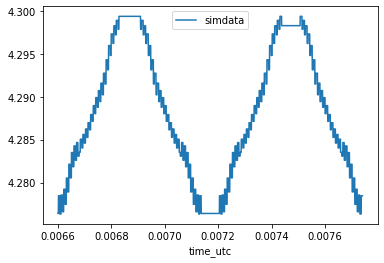

In [12]:
tod_sim.plot(x='time_utc',y='simdata');

___


### Section 4: The MCMC

The goal of is to get the posteriors of the beam parameters given data. There are 18 beam parameters in total: 
- 6 parameters for the main "A" beam: mainA_amp, mainA_x, mainA_y, mainA_sigx, mainA_sigy, mainA_corr
- 6 parameters for the main "B" beam: mainB_amp, mainB_x, mainB_y, mainB_sigx, mainB_sigy, mainB_corr
- 6 parameters for the extended beam: ext_amp, ext_x, ext_y, ext_sigx, ext_sigy, ext_corr

We are also going to allow an arbitrary error $\sigma$ for the timestream data that will be fixed for now. As can be seen from the plot below, by nudging $p_0$  a little bit in either direction, the output timestream changes. We know that the true parameter is 0.1, and we will ask emcee to give us this very value

<Figure size 432x288 with 0 Axes>

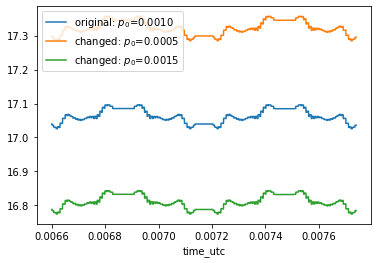

In [13]:
plt.figure()
p0 = 0.001
this = model.observe(extended=[p0,30,0,30,30,1])
ax = this.plot(x='time_utc',y='simdata', label='original: $p_0$={:.4f}'.format(p0))
#plt.plot(tod_sim["simdata"].values-tod_sim2["simdata"])
values = [0.0005,0.0015]

for p0 in values:
    this = model.observe(extended=[p0,30,0,30,30,1])
    #plt.plot(tod_sim["simdata"].values-this["simdata"])
    this.plot(x='time_utc',y='simdata', ax=ax, label='changed: $p_0$={:.4f}'.format(p0))
plt.show()

## Inference Test #1
Least Squares Fit: The goal of the following simple inference test is to get an approximation to the maximum a posteriori (MAP) of the 18 parameters for the beam, given data ("pair-difference" timestreams between two detectors on a telescope as it scans across the sky.)

We could use this result as an initial guess in a full-posterior inference test that uses MCMC (Inference Test #2). For now, we first wrap our model output in a wrapper function so that it can be used in scipy.curve_fit.optimize

In [14]:
true_vals = np.array([1,0,0,1,1,1,
                      1,0.1,0,1,1,
                      1,0.1,30,0,30,30,1])

In [15]:
model_wrapped = gm.GenModelMap(tod,\
                            det_info,\
                            nside=nside,\
                            main_beam_params_A=[1,0,0,1,1,1],\
                            main_beam_params_B=[1,0.1,0,1,1,1],\
                            ext_beam_params=[0.1,30,0,30,30,1])

y = (model_wrapped.observe())['simdata'].values.copy()

def wrapper(x, mainA_amp,mainA_x,mainA_y,mainA_sigx,mainA_sigy,mainA_corr,
               mainB_amp,mainB_x,mainB_y,mainB_sigx,mainB_sigy,mainB_corr,
               ext_amp,ext_x,ext_y,ext_sigx,ext_sigy,ext_corr):
    out = model_wrapped.observe(mainA=[mainA_amp,mainA_x,mainA_y,mainA_sigx,mainA_sigy,mainA_corr],\
                                mainB=[mainB_amp,mainB_x,mainB_y,mainB_sigx,mainB_sigy,mainB_corr],\
                                extended=[ext_amp,ext_x,ext_y,ext_sigx,ext_sigy,ext_corr])
    return out['simdata'].values.copy()

/n/home05/grabanal/.conda/envs/phys201/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Current map NSIDE=512. Converting to NSIDE=64


In [16]:
# Bounds for the 18 parameters
bounds = ([0, -7, -7, 0, 0, -1, 0, -7, -7, 0, 0, -1, 0, -30, -30,  0,  0, -1], 
          [2,  7,  7, 2, 2,  1, 2,  7,  7, 2, 2,  1, 2,  30,  30, 50, 50,  1])

# Fit
curve_fit_result = scipy.optimize.curve_fit(wrapper, 
                                            None, 
                                            y,
                                            bounds=bounds,
                                            sigma=np.ones(len(tod_sim))*1e-10,
                                            absolute_sigma=True)

In [17]:
def print_result(best_fit_vals, covariance_matrix):
    """
    Prints out the best fit values one by one, and then their covariance matrix
    
    Parameters:
        (best_fit_vals, covariance_matrix): tuple, a result of scipy.optimize.curve_fit
    """

    uncertainties = np.sqrt(np.diag(covariance_matrix))
    print("Least-squares best fit values and uncertainties:\n")
    names=['mainA_amp','mainA_x','mainA_y','mainA_sigx','mainA_sigy','mainA_corr',
           'mainB_amp','mainB_x','mainB_y','mainB_sigx','mainB_sigy','mainB_corr',
           'ext_amp','ext_x','ext_y','ext_sigx','ext_sigy','ext_corr']
    for value, sigma, name in zip(best_fit_vals, uncertainties, names):
        print('{} = {:.3} ± {:.3}'.format(name, value, sigma))
    print()
#     print("Covariance matrix:")
#     print("{}".format(covariance_matrix))
    
print_result(*curve_fit_result)

Least-squares best fit values and uncertainties:

mainA_amp = 1.53 ± 3.47e-08
mainA_x = 0.342 ± 2.55e-05
mainA_y = -0.0341 ± 4.55e-05
mainA_sigx = 1.35 ± 2.45e-08
mainA_sigy = 1.24 ± 5.43e-05
mainA_corr = -0.0932 ± 6.24e-05
mainB_amp = 1.53 ± 3.37e-08
mainB_x = -0.0124 ± 2.55e-05
mainB_y = -0.146 ± 3.71e-05
mainB_sigx = 1.31 ± 6.98e-05
mainB_sigy = 1.35 ± 6.71e-05
mainB_corr = 0.138 ± 7.74e-05
ext_amp = 0.363 ± 1.69e-09
ext_x = -0.289 ± 6.39e-05
ext_y = -0.129 ± 7.11e-05
ext_sigx = 19.8 ± 0.00106
ext_sigy = 19.7 ± 0.00106
ext_corr = 0.0669 ± 9.81e-05



Now let's compare the output of those best-fit parameters to the output of the true parameters:

<Figure size 432x288 with 0 Axes>

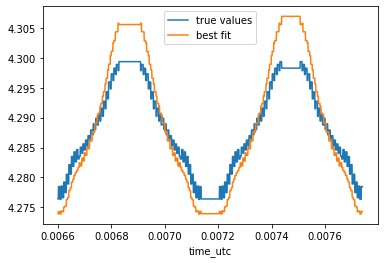

In [18]:
true_list      = true_vals.tolist()
best_fit_list  = (curve_fit_result[0]).tolist()

plt.figure()

this = model.observe(mainA=true_list[0:6], mainB=true_list[6:12], extended=true_list[12:18])
ax = this.plot(x='time_utc',y='simdata', label='true values')
this = model.observe(mainA=best_fit_list[0:6], mainB=best_fit_list[6:12], extended=best_fit_list[12:18])
this.plot(x='time_utc',y='simdata', ax=ax, label='best fit')

plt.show()

So, we can see that the linear squares fit is very bad without a good initial guess. On the other hand, if we use the true parameters as initial guess, then the result is what is expected:

In [19]:
curve_fit_result = scipy.optimize.curve_fit(wrapper, 
                                            None, 
                                            y,
                                            p0=true_vals,
                                            bounds=bounds,
                                            sigma=np.ones(len(tod_sim))*1e-10,
                                            absolute_sigma=True)

Least-squares best fit values and uncertainties:

mainA_amp = 1.0 ± 1.01e-08
mainA_x = 1.23e-12 ± 6.18e-09
mainA_y = -2.58e-13 ± 5.7e-05
mainA_sigx = 1.0 ± 1.79e-08
mainA_sigy = 1.0 ± 2.56e-08
mainA_corr = 1.0 ± 3.1e-18
mainB_amp = 1.0 ± 9.1e-09
mainB_x = 0.1 ± 2.19e-05
mainB_y = 3.1e-13 ± 7.31e-06
mainB_sigx = 1.0 ± 1.72e-08
mainB_sigy = 1.0 ± 2.52e-08
mainB_corr = 1.0 ± 1.24e-19
ext_amp = 0.1 ± 3.77e-10
ext_x = 30.0 ± 1.8e-08
ext_y = -2.82e-13 ± 8.8e-05
ext_sigx = 30.0 ± 1.17e-07
ext_sigy = 30.0 ± 1.07e-07
ext_corr = 1.0 ± 0.0



<Figure size 432x288 with 0 Axes>

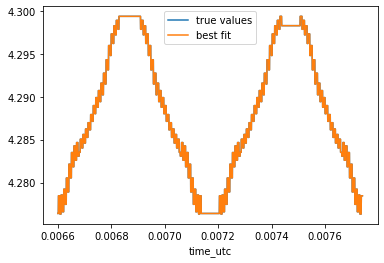

In [20]:
print_result(*curve_fit_result)

true_list      = true_vals.tolist()
best_fit_list  = (curve_fit_result[0]).tolist()

plt.figure()

this = model.observe(mainA=true_list[0:6], mainB=true_list[6:12], extended=true_list[12:18])
ax = this.plot(x='time_utc',y='simdata', label='true values')
this = model.observe(mainA=best_fit_list[0:6], mainB=best_fit_list[6:12], extended=best_fit_list[12:18])
this.plot(x='time_utc',y='simdata', ax=ax, label='best fit')

plt.show()

## Inference Test #2

We are going to use the emcee MCMC generator. The value that is going be compared between iterations is the 'simdata' (simulated data) argument of the timestream dataframes, the same that has been graphed above.

Then, the rationale is to feed the **output** timestream that we get from a model that uses the true parameters, to an emcee  MCMC generator to infer the best-fit model beam parameters that produce an output timestream that is the closest. As we said previously, we are going to infer the parameters (which **we know** have some true values)

In [21]:
tod = xb.io.keep_scans(tod_full,scans,[0,1,2,3])

# Should I get rid of these two lines?
# # Comment these two lines if we want to do real data.
# tod["A_sig"] = tod_sim["simdata"]
# tod["B_sig"] = np.zeros(np.shape(tod["B_sig"].values))

# Creating simulated input data from our known true values
model = gm.GenModelMap(tod,\
    det_info,\
    nside=nside,\
    main_beam_params_A=[1,0,0,1,1,1],\
    main_beam_params_B=[1,0.1,0,1,1,1],\
    ext_beam_params=[0.1,30,0,30,30,1])
tod_sim = model.observe()
tod['inputdata'] = tod_sim['simdata'].copy()

# Initializing the model with this new full tod
model = gm.GenModelMap(tod,\
    det_info,\
    nside=nside)

/n/home05/grabanal/.conda/envs/phys201/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Current map NSIDE=512. Converting to NSIDE=64
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Current map NSIDE=512. Converting to NSIDE=64


Just to check how long this MCMC process will take, let's do 40 walkers with only 10 steps

In [22]:
# Bounds for the 18 parameters
bounds = ([0, -7, -7, 0, 0, -1, 0, -7, -7, 0, 0, -1, 0, -30, -30,  0,  0, -1], 
          [2,  7,  7, 2, 2,  1, 2,  7,  7, 2, 2,  1, 2,  30,  30, 50, 50,  1])

# Initial guess, same as the true values but tweaked a little bit away from the bounds
epsilon = 0.02
initial_guess = np.array([1,0,0,1,1,1-epsilon,
                          1,0.1,0,1,1,1-epsilon,
                          0.1,30-epsilon,0,30,30,1-epsilon])

%time _ = model.do_emcee_fit(N_walkers=40, N_steps=10, initial_guess=initial_guess, gaussian_ball_width=1e-6, sigma=1e-10)

Starting with 48 CPUs
CPU times: user 1.92 s, sys: 752 ms, total: 2.67 s
Wall time: 10.2 s


**The following MCMC process will take 600 times more** so take your time, or otherwise **change the number of steps** to something more manageable. I recommend running this with many cores

In [23]:
%time emcee_chains = model.do_emcee_fit(N_walkers=40, N_steps=6000, initial_guess=initial_guess, gaussian_ball_width=1e-6, sigma=1e-10)


Starting with 48 CPUs
CPU times: user 17min 7s, sys: 4min 25s, total: 21min 32s
Wall time: 1h 22min 4s


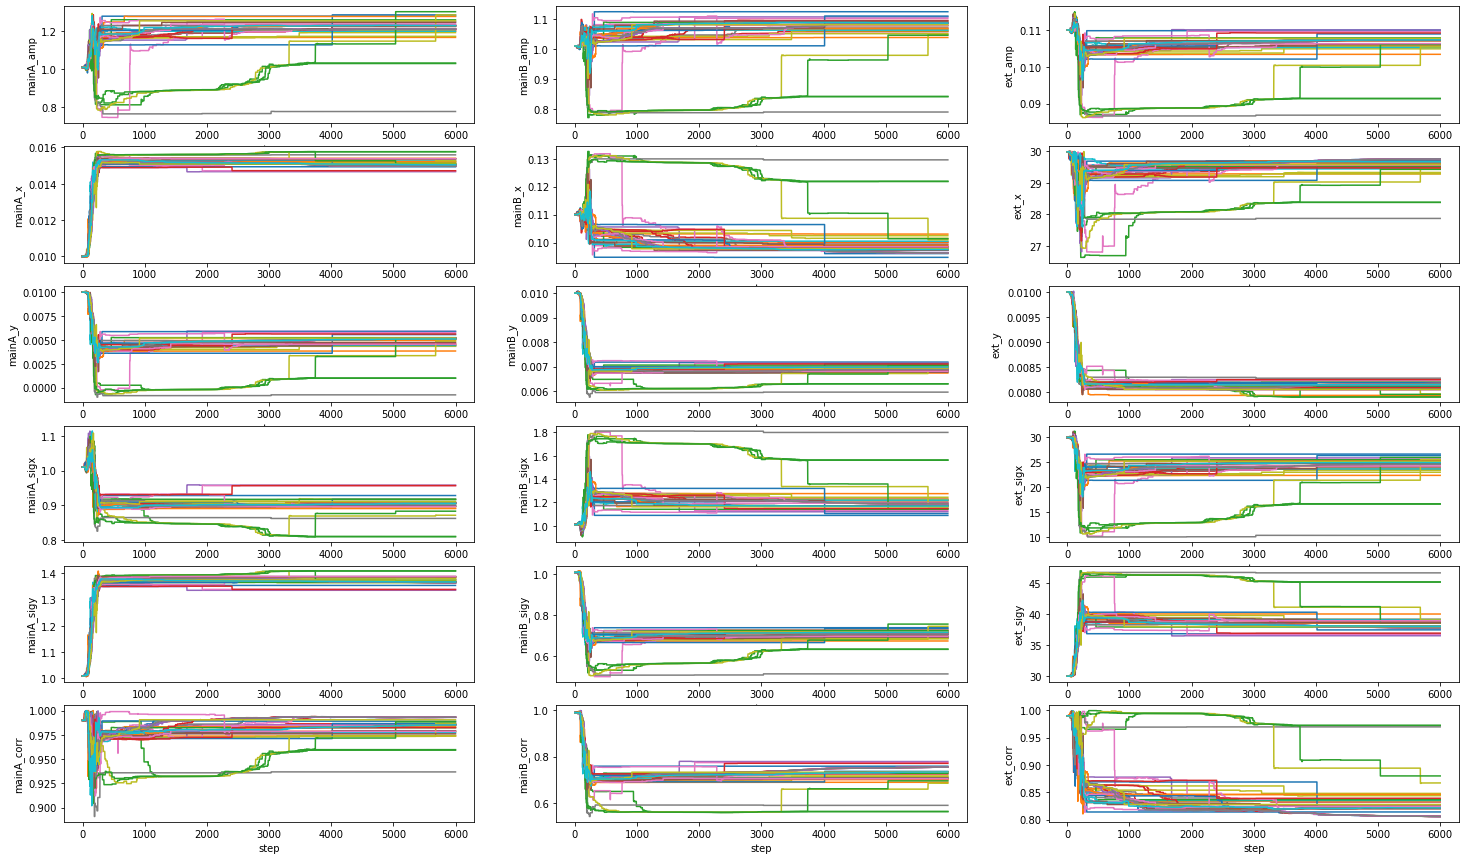

In [24]:
model.plot_emcee_chains(nchains=40)

It looks like the burn-in time is around 50 steps. We'll remove the first 50 just to be safe

In [25]:
burned_in = emcee_chains.xs(slice(50, 2000), level=1)

Posterior for the first parameter, mainA_amp


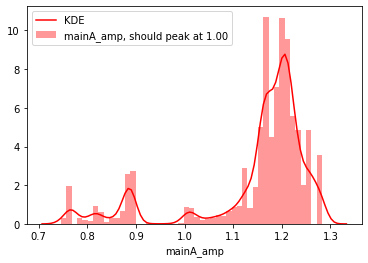

In [26]:
plt.figure()
print("Posterior for the first parameter, mainA_amp")
sns.distplot(burned_in['mainA_amp'], 
             color='r', 
             hist_kws={'label':'mainA_amp, should peak at {:.2f}'.format(1.0)},
             kde_kws={'label': 'KDE'})
plt.show()

Posteriors for the parameters of the main + extended beam:


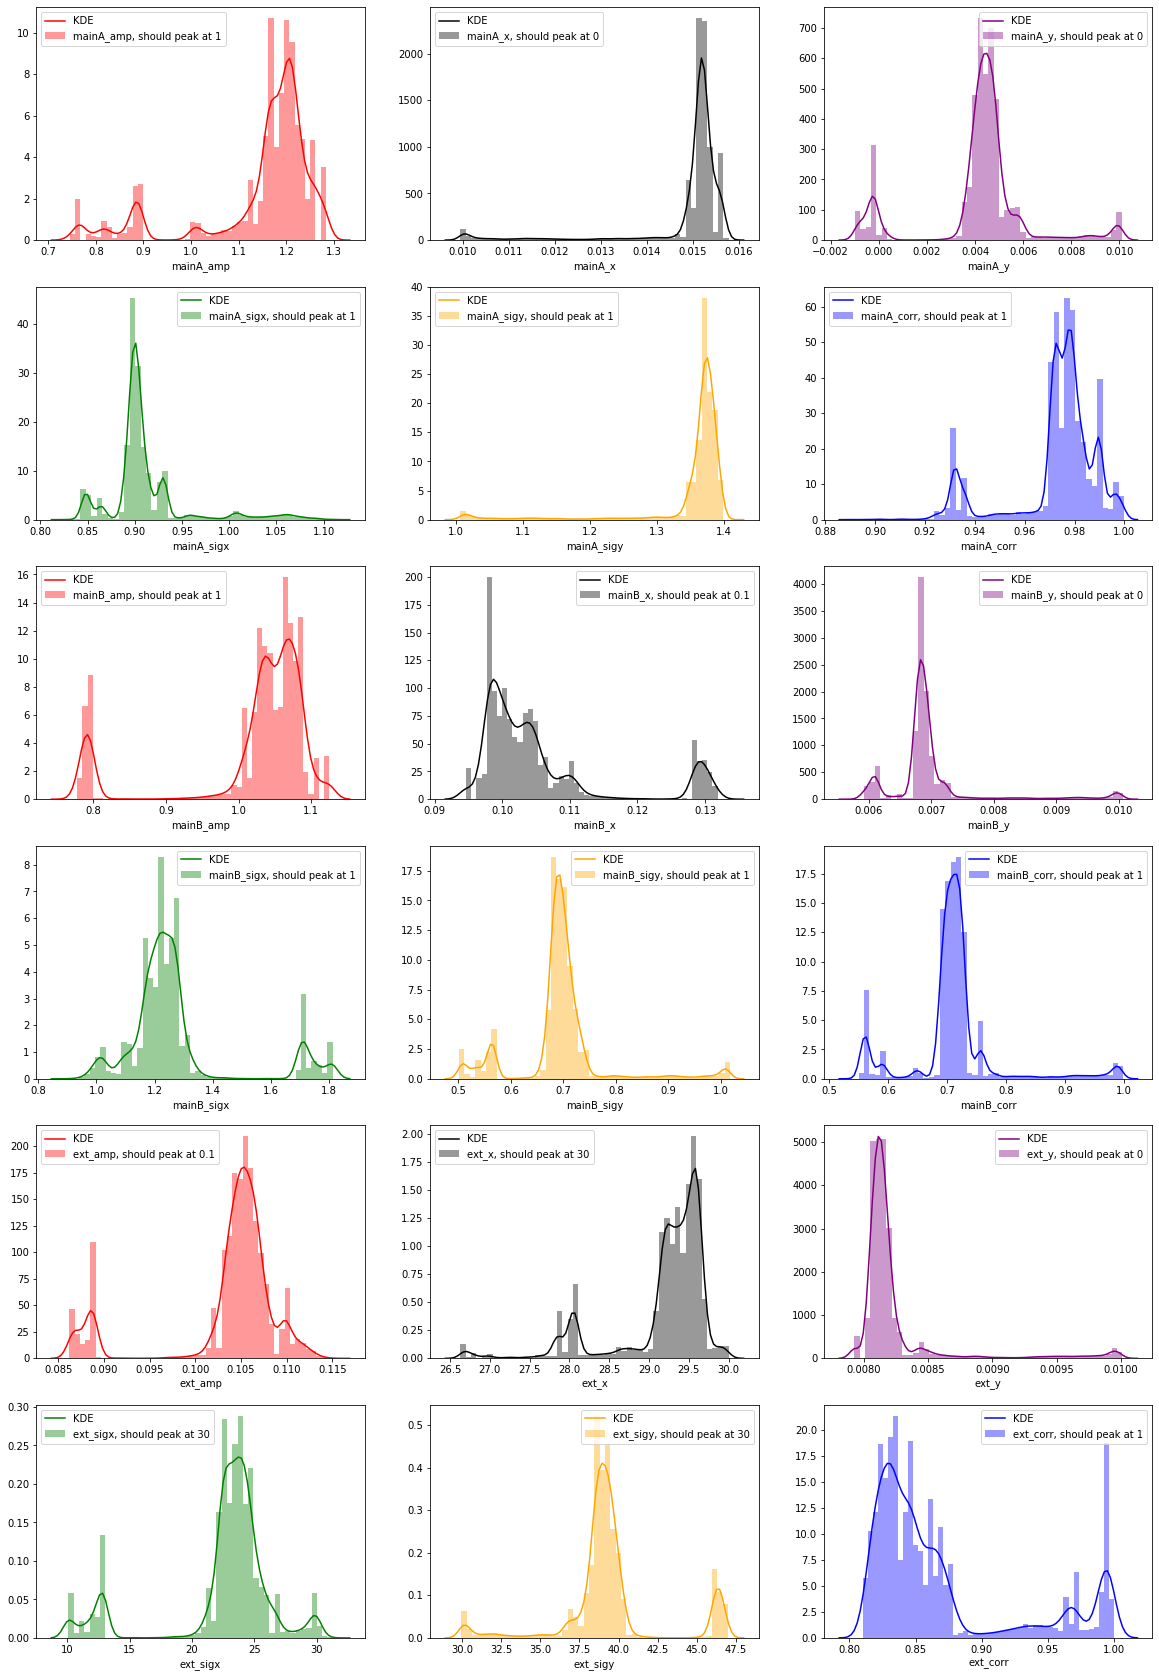

In [27]:
f, axes     = plt.subplots(6, 3, figsize=(20, 30))
names       = np.array(emcee_chains.columns)
true_vals   = [1,0,0,1,1,1,1,0.1,0,1,1,1,0.1,30,0,30,30,1] # true values
colors  = ['red', 'black', 'purple', 'green', 'orange', 'blue',
           'red', 'black', 'purple', 'green', 'orange', 'blue',
           'red', 'black', 'purple', 'green', 'orange', 'blue']

print("Posteriors for the parameters of the main + extended beam:")

for ax, feature, color, name, peak in zip(axes.flat, burned_in.columns, colors, names, true_vals):
    sns.distplot(burned_in[feature], 
                 color=color, 
                 ax=ax, 
                 hist_kws={'label':'{}, should peak at {}'.format(name, peak)},
                 kde_kws={'label': 'KDE'})

Amplitudes for the mean parameter beam: 
Expected to peak at (1, 1)


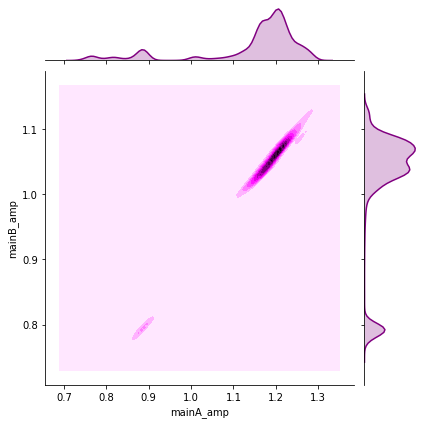

In [28]:
print("Amplitudes for the mean parameter beam: \nExpected to peak at (1, 1)")
sns.jointplot(x='mainA_amp', y='mainB_amp', data=burned_in, kind='kde', color='purple');